In [45]:
from datetime import datetime
from pathlib import Path

# 設定値

## WAVEファイルのパス
wav_dir = Path(r"D:\Diana\新千歳空港\WAVE")
## 測定局ID
stid = "CH53"
## 校正完了時間
calibrated_time = datetime(year=2022,month=12,day=1,hour=0,minute=0,second=0)
## サンプルサイズ
sample_size = 385

center_freqs = [250,500,1000,2000,4000]
tap = 1024
percentile = 90
mean_time_sec = 0.1


In [46]:
# WAVファイルを集める

from datetime import timedelta
import learning_test as ln

time = calibrated_time
wav_file_list = []
while len(wav_file_list) < sample_size:
    event_time, path = ln.get_event_time(stid, wav_dir, time)
    if not event_time:
        print("失敗")
        break
    wav_file_list.append(path)
    time = event_time + timedelta(seconds = 1)

print(len(wav_file_list))


385


C:\Users\noedl\AppData\Local\Temp\ipykernel_11948\570994971.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([dataset,pd.DataFrame([data_list], columns=columns)], axis=0)


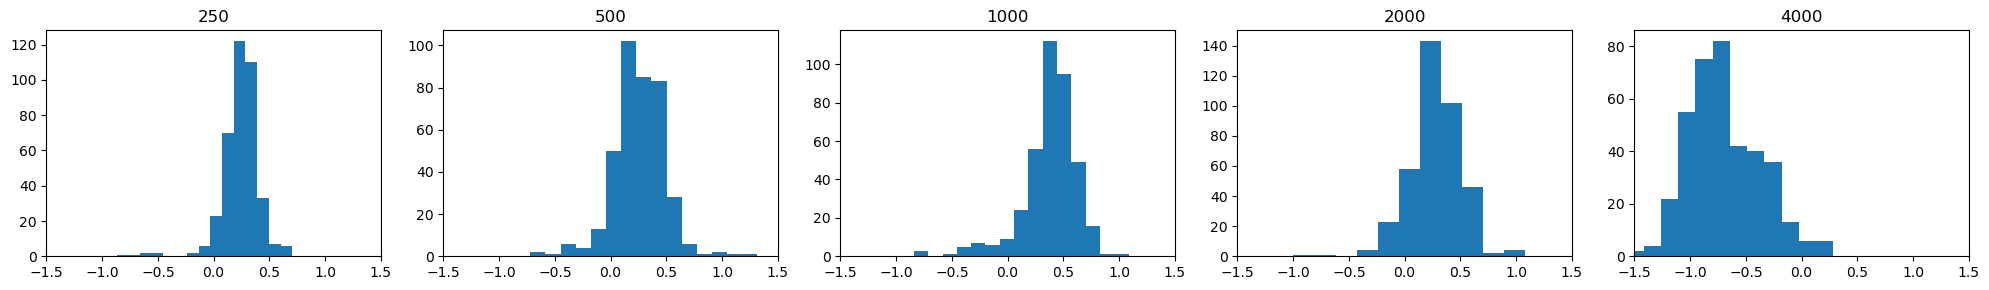

In [47]:
# 異常検知パラメータを求める
import pandas as pd
import learning_test as ln
import matplotlib.pyplot as plt

columns = list(map(str,center_freqs))
dataset = pd.DataFrame(columns=columns)
for file in wav_file_list:
    fs, signal = ln.wav_load(file)
    oct_freq_masks = ln.make_oct_masks(center_freqs, tap, fs)
    data_list = ln.detect_diff_data(signal, tap, oct_freq_masks, fs, mean_time_sec, percentile)
    dataset = pd.concat([dataset,pd.DataFrame([data_list], columns=columns)], axis=0)

fig = plt.figure(figsize=(20, 3))
i = 1
for freq in oct_freq_masks.keys():
    exec("h"+ str(i) + "=fig.add_subplot(1,5," + str(i) + ")")
    exec("h"+ str(i) + ".hist(dataset[freq],bins=15)")
    exec("h"+ str(i) + ".set_title(freq)")
    label = [str]
    plt.xlim([-1.5,1.5])
    i += 1

fig.tight_layout()
plt.show()


In [48]:
# 外れ値の除外 smirnovgrubbs検定
import pandas as pd
o_dataset = {f'{freq}': list() for freq in oct_freq_masks.keys()}
for freq in oct_freq_masks.keys():
    o_dataset[freq], out = ln.smirnov_grubbs(list(dataset[freq]), 0.2)
    print(out)



[-0.87097422 -0.67030926 -0.59919165 -0.567831   -0.51983998 -0.51209696
  0.70611783]
[-0.72045899 -0.70550917 -0.5250446   1.00845328  1.01232263  1.13960318
  1.3167067 ]
[-0.84067307 -0.82590854 -0.81540243 -0.57951702 -0.3907882  -0.38807223
 -0.37819951 -0.35336371 -0.33483567 -0.30125665 -0.29845663 -0.27707185
 -0.24720702 -0.2466882   1.08392528]
[-1.75350265 -0.81971195 -0.78461666  1.00920539  1.08074431]
[-2.03705036]


250:外れ値除去前:size=385 平均=0.24 標準偏差=0.171 誤差=0.009 歪度=-2.007 尖度=10.087
250:外れ値除去後:size=378 平均=0.252 標準偏差=0.13 誤差=0.007 歪度=-0.061 尖度=0.815

500:外れ値除去前:size=385 平均=0.256 標準偏差=0.23 誤差=0.012 歪度=-0.142 尖度=3.339
500:外れ値除去後:size=378 平均=0.254 標準偏差=0.197 誤差=0.01 歪度=-0.352 尖度=0.625

1000:外れ値除去前:size=385 平均=0.379 標準偏差=0.248 誤差=0.013 歪度=-1.624 尖度=4.938
1000:外れ値除去後:size=370 平均=0.408 標準偏差=0.184 誤差=0.01 歪度=-0.548 尖度=0.692

2000:外れ値除去前:size=385 平均=0.267 標準偏差=0.249 誤差=0.013 歪度=-1.683 尖度=12.141
2000:外れ値除去後:size=380 平均=0.274 標準偏差=0.207 誤差=0.011 歪度=-0.174 尖度=0.427

4000:外れ値除去前:size=385 平均=-0.7 標準偏差=0.332 誤差=0.017 歪度=0.247 尖度=0.719
4000:外れ値除去後:size=384 平均=-0.696 標準偏差=0.325 誤差=0.017 歪度=0.413 尖度=0.278



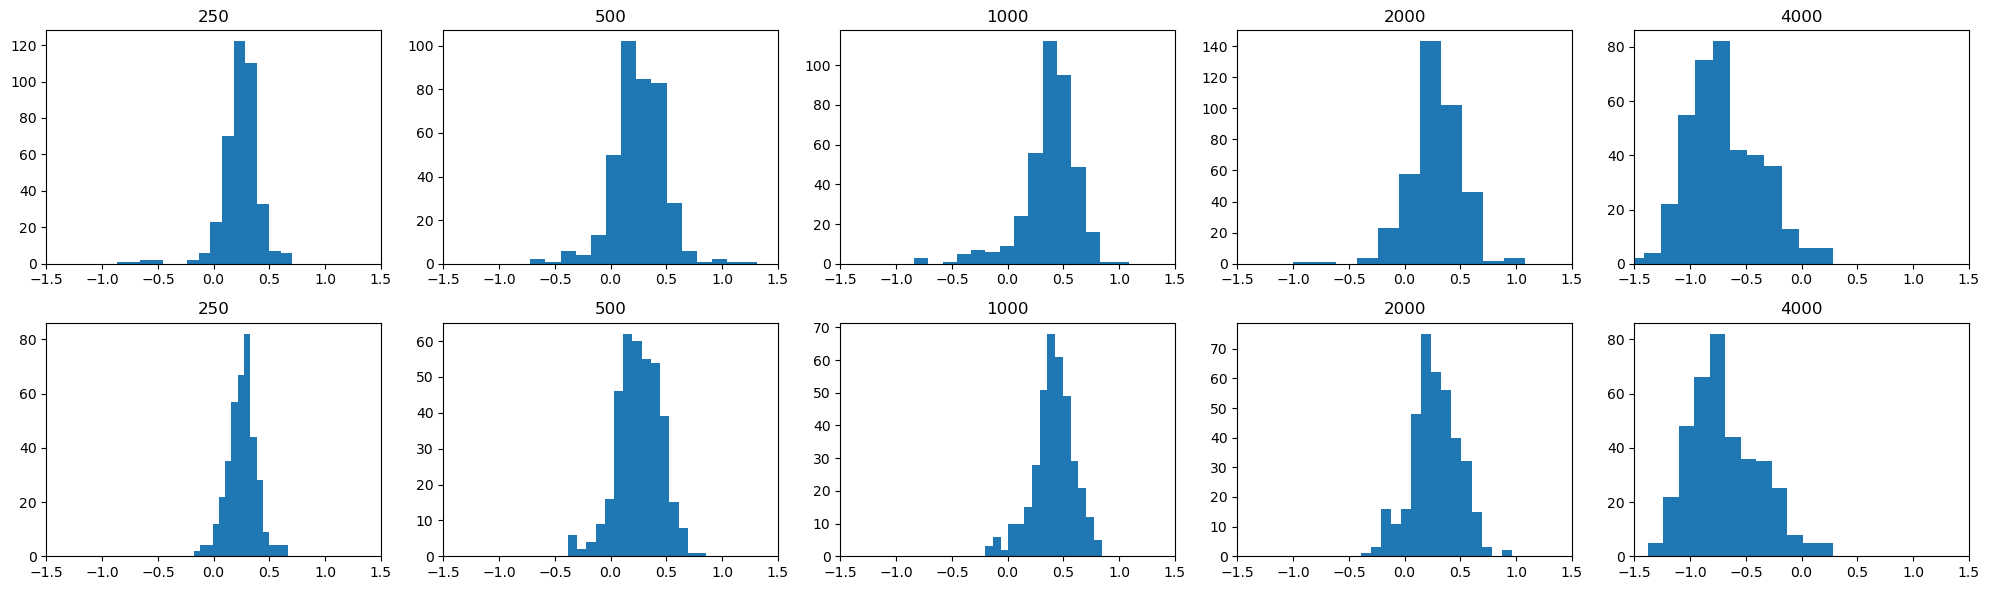

In [49]:
# 分布の表示

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis, skew

def get_statics(data_list):
    n = len(data_list)
    std = round(np.std(data_list,ddof=1),3)
    se = round(std/np.sqrt(n),3)
    mean = round(np.mean(data_list),3)
    sk = round(skew(data_list),3)
    ku = round(kurtosis(data_list),3)

    return n,std,se,mean,sk,ku

fig = plt.figure(figsize=(20, 6))
i = 1
for freq in oct_freq_masks.keys():
    exec("h"+ str(i) + "=fig.add_subplot(2,5," + str(i) + ")")
    exec("h"+ str(i) + ".hist(dataset[freq],bins=15)")
    exec("h"+ str(i) + ".set_title(freq)")
    label = [str]
    n,std,se,mean,sk,ku = get_statics(dataset[freq])
    print(f"{str(freq)}:外れ値除去前:size={n} 平均={mean} 標準偏差={std} 誤差={se} 歪度={sk} 尖度={ku}")
    plt.xlim([-1.5,1.5])
    exec("h"+ str(i+5) + "=fig.add_subplot(2,5," + str(i+5) + ")")
    exec("h"+ str(i+5) + ".hist(o_dataset[freq],bins=15)")
    exec("h"+ str(i+5) + ".set_title(freq)")
    label = [str]
    n,std,se,mean,sk,ku = get_statics(o_dataset[freq])
    print(f"{str(freq)}:外れ値除去後:size={n} 平均={mean} 標準偏差={std} 誤差={se} 歪度={sk} 尖度={ku}\n")
    plt.xlim([-1.5,1.5])
    i += 1

fig.tight_layout()
plt.show()

250:除去後:平均=0.252 標準偏差=0.13 誤差=0.007 歪度=-0.061 尖度=0.815
250:変換後:平均=0.26 標準偏差=0.136 誤差=0.007 歪度=0.033 尖度=0.815

500:除去後:平均=0.254 標準偏差=0.197 誤差=0.01 歪度=-0.352 尖度=0.625
500:変換後:平均=0.286 標準偏差=0.225 誤差=0.012 歪度=0.025 尖度=0.286

1000:除去後:平均=0.408 標準偏差=0.184 誤差=0.01 歪度=-0.548 尖度=0.692
1000:変換後:平均=0.534 標準偏差=0.27 誤差=0.014 歪度=0.01 尖度=0.119

2000:除去後:平均=0.274 標準偏差=0.207 誤差=0.011 歪度=-0.174 尖度=0.427
2000:変換後:平均=0.293 標準偏差=0.224 誤差=0.011 歪度=0.031 尖度=0.438

4000:除去後:平均=-0.696 標準偏差=0.325 誤差=0.017 歪度=0.413 尖度=0.278
4000:変換後:平均=-0.873 標準偏差=0.447 誤差=0.023 歪度=-0.002 尖度=0.323



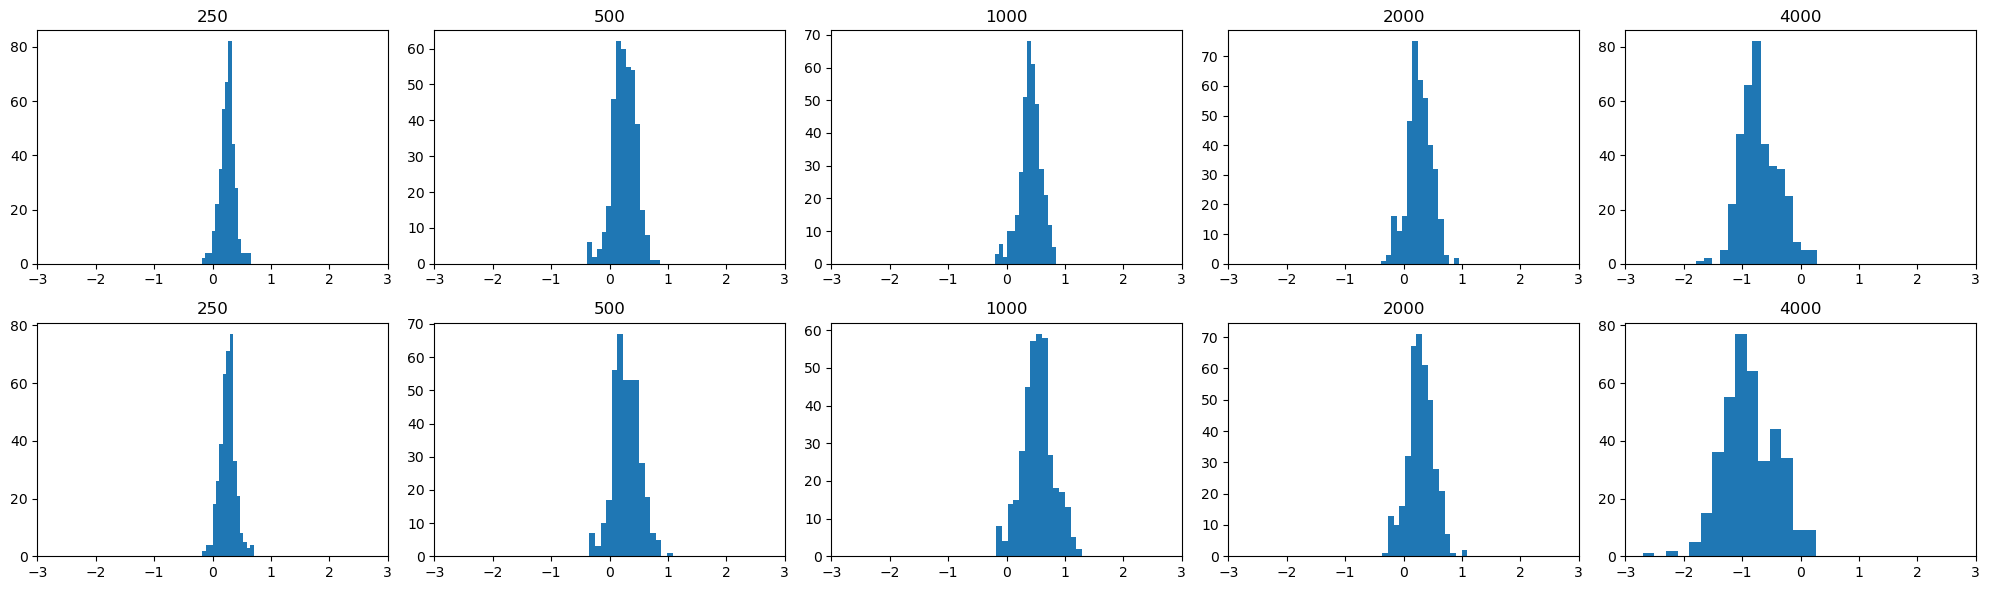

In [50]:
# スケーリング
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler
import itertools

rb = RobustScaler(with_centering=False,with_scaling=True)
pt = PowerTransformer(standardize=False)
fig = plt.figure(figsize=(20, 6))

i = 1
t_dataset = {f'{freq}': list() for freq in oct_freq_masks.keys()}
for freq in oct_freq_masks.keys():
    df = pd.DataFrame(o_dataset[freq],copy=True)

    # df[:] = rb.fit_transform(df[:])
    df[:] = pt.fit_transform(df[:])

    t_dataset[freq] = list(itertools.chain.from_iterable(df.values.tolist()))

    exec("h"+ str(i) + "=fig.add_subplot(2,5," + str(i) + ")")
    exec("h"+ str(i) + ".hist(o_dataset[freq],bins=15)")
    exec("h"+ str(i) + ".set_title(freq)")
    plt.xlim([-3,3])
    label = [str]
    n,std,se,mean,sk,ku = get_statics(o_dataset[freq])
    print(f"{str(freq)}:除去後:平均={mean} 標準偏差={std} 誤差={se} 歪度={sk} 尖度={ku}")

    exec("h"+ str(i+5) + "=fig.add_subplot(2,5," + str(i+5) + ")")
    exec("h"+ str(i+5) + ".hist(t_dataset[freq],bins=15)")
    exec("h"+ str(i+5) + ".set_title(freq)")
    plt.xlim([-3,3])
    label = [str]
    n,std,se,mean,sk,ku = get_statics(t_dataset[freq])
    print(f"{str(freq)}:変換後:平均={mean} 標準偏差={std} 誤差={se} 歪度={sk} 尖度={ku}\n")


    i += 1

fig.tight_layout()
plt.show()

d:\miniconda3\envs\soundvalid\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\miniconda3\envs\soundvalid\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


              RSS         AIC         BIC
norm     0.198809  474.800749  482.702034
gamma    0.198358  476.801346  488.653274
lognorm  0.190946  476.887409  488.739337
cauchy   0.437895  610.390337  618.291622
t        0.205346  475.960319  487.812247


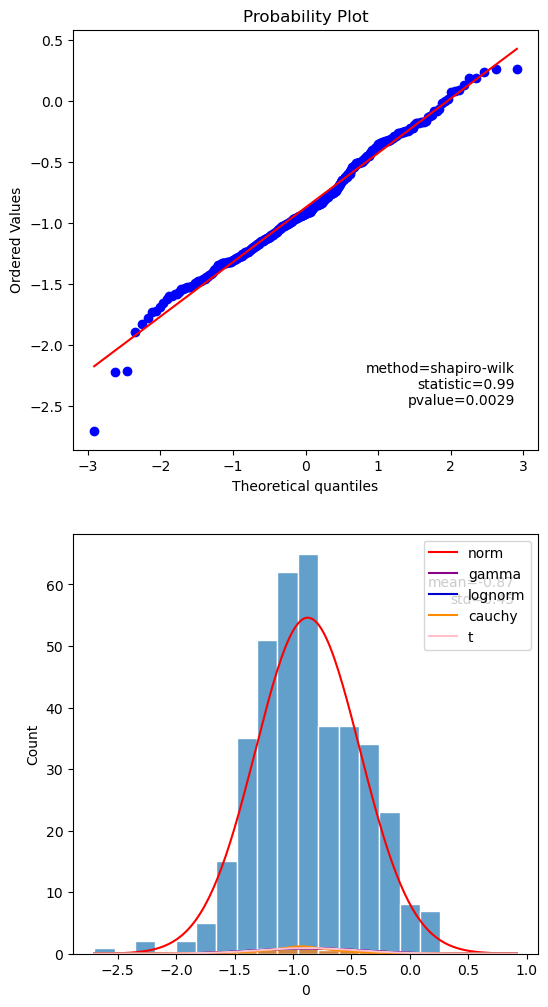

In [71]:
from seaborn_analyzer import hist
target_freq  = "4000"

t_df = pd.DataFrame(t_dataset[target_freq],copy=True)
o_df = pd.DataFrame(o_dataset[target_freq],copy=True)

hist.plot_normality(t_df, x=0, rounddigit=2)
all_params, all_scores = hist.fit_dist(t_df, x=0, dist=['norm', 'gamma', 'lognorm','cauchy','t'])
df_scores = pd.DataFrame(all_scores).T
print(df_scores)